Louvain clustering over data

Importing all the libraries

In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from sknetwork.clustering import Louvain
import h5py
import numpy as np
import pickle

Reading the dataset

In [ ]:

vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'
vgg16_content = h5py.File(vgg16_path, mode='r')

In [3]:
vgg16_content


<HDF5 file "vgg16_dim_reduced_feature.h5" (mode r)>

In [4]:
vgg16_pca_feature  = vgg16_content['pca_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]


In [5]:
vgg16_pca_feature


array([[ -90.864815 ,  107.03243  ,  116.16385  , ...,    8.259951 ,
          -1.1383446,   -9.175951 ],
       [ -74.06226  ,  117.31615  ,   95.24547  , ...,   -1.9739974,
           6.8172655,    4.2547903],
       [ -81.875336 ,  122.84872  ,   83.767784 , ...,   -1.3287221,
          13.65623  ,  -11.109545 ],
       ...,
       [  32.70835  ,   31.183935 ,  -47.30978  , ...,    4.2004256,
           3.599823 ,    6.0058775],
       [ -39.911785 , -105.81029  ,  122.37118  , ...,  -14.908715 ,
          -1.1814455,  -10.837135 ],
       [  32.35425  ,  -50.3373   ,   66.50197  , ...,   -3.859397 ,
          -1.047523 ,    2.3827858]], dtype=float32)

In [6]:
vgg16_umap_feature  = vgg16_content['umap_feature'][...]


Labeling the Dataset 

In [7]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(vgg16_content['file_name'])
filename = np.array([str(x) for x in filename])
labels = np.array([x.split('/')[2] for x in filename])
labels

array(['ADI', 'ADI', 'ADI', ..., 'TUM', 'TUM', 'TUM'], dtype='<U4')

Random subset of dataset for clustering

In [8]:
#Umap datset of VGG
import random
random.seed(0)
selected_index = random.sample(list(np.arange(len(vgg16_umap_feature))), 1000)
test_data = vgg16_umap_feature[selected_index]
test_label = labels[selected_index]

In [9]:
#PCA datset of VGG

import random
random.seed(0)
selected_index_umap = random.sample(list(np.arange(len(vgg16_umap_feature))), 1000)
test_data_umap = vgg16_umap_feature[selected_index_umap]
test_label_umap = labels[selected_index_umap]

Plotting the dataset for Visualization

In [ ]:
#plotting the dataset using plotly library
import plotly.graph_objects as go
import pandas as pd
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of VGG16's PCA feature",
    legend_title="Legend Title",
)

fig.show()

/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning: plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.

  DeprecationWarning,
/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:494: DeprecationWarning: plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene

  DeprecationWarning,


In [ ]:
#checking the length of teh dataset vgg umap
len(vgg16_umap_feature)

5000

In [ ]:
#checking the length of vgg pca
len(vgg16_pca_feature)

5000

Applying the Louvain algorithm to teh dataset 

In [ ]:
###Applying the Louvain algorithm to the dataset 

# Step 1: Create a nearest neighbors graph
knn_graph = kneighbors_graph(test_data, n_neighbors=10, mode='connectivity', include_self=False)
adjacency_matrix = knn_graph.toarray()

# Step 2: Apply Louvain clustering
louvain = Louvain(resolution=0.1)
louvain_labels = louvain.fit_transform(adjacency_matrix)

# Step 3: Analyze the clustering results
print('Number of clusters from Louvain: %d' % len(np.unique(louvain_labels)))
louvain_counts = np.unique(louvain_labels, return_counts=True)
print('Louvain assignment counts')
cluster_df = pd.DataFrame({'Cluster Index': louvain_counts[0], 'Number of members': louvain_counts[1]}).set_index('Cluster Index')
print(cluster_df)

# Step 4: Calculate evaluation metrics
louvain_silhouette = silhouette_score(test_data, louvain_labels)
louvain_v_measure = v_measure_score(test_label, louvain_labels)

metrics_df = pd.DataFrame({
    'Metrics': ['silhouette', 'V-measure'],
    'Louvain': [louvain_silhouette, louvain_v_measure]
}).set_index('Metrics')

print(metrics_df)


Number of clusters from Louvain: 10
Louvain assignment counts
               Number of members
Cluster Index                   
0                            226
1                            185
2                            164
3                            101
4                             95
5                             84
6                             46
7                             44
8                             28
9                             27
             Louvain
Metrics             
silhouette  0.456341
V-measure   0.692790


Plotting the stack bar graph of the clusters

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



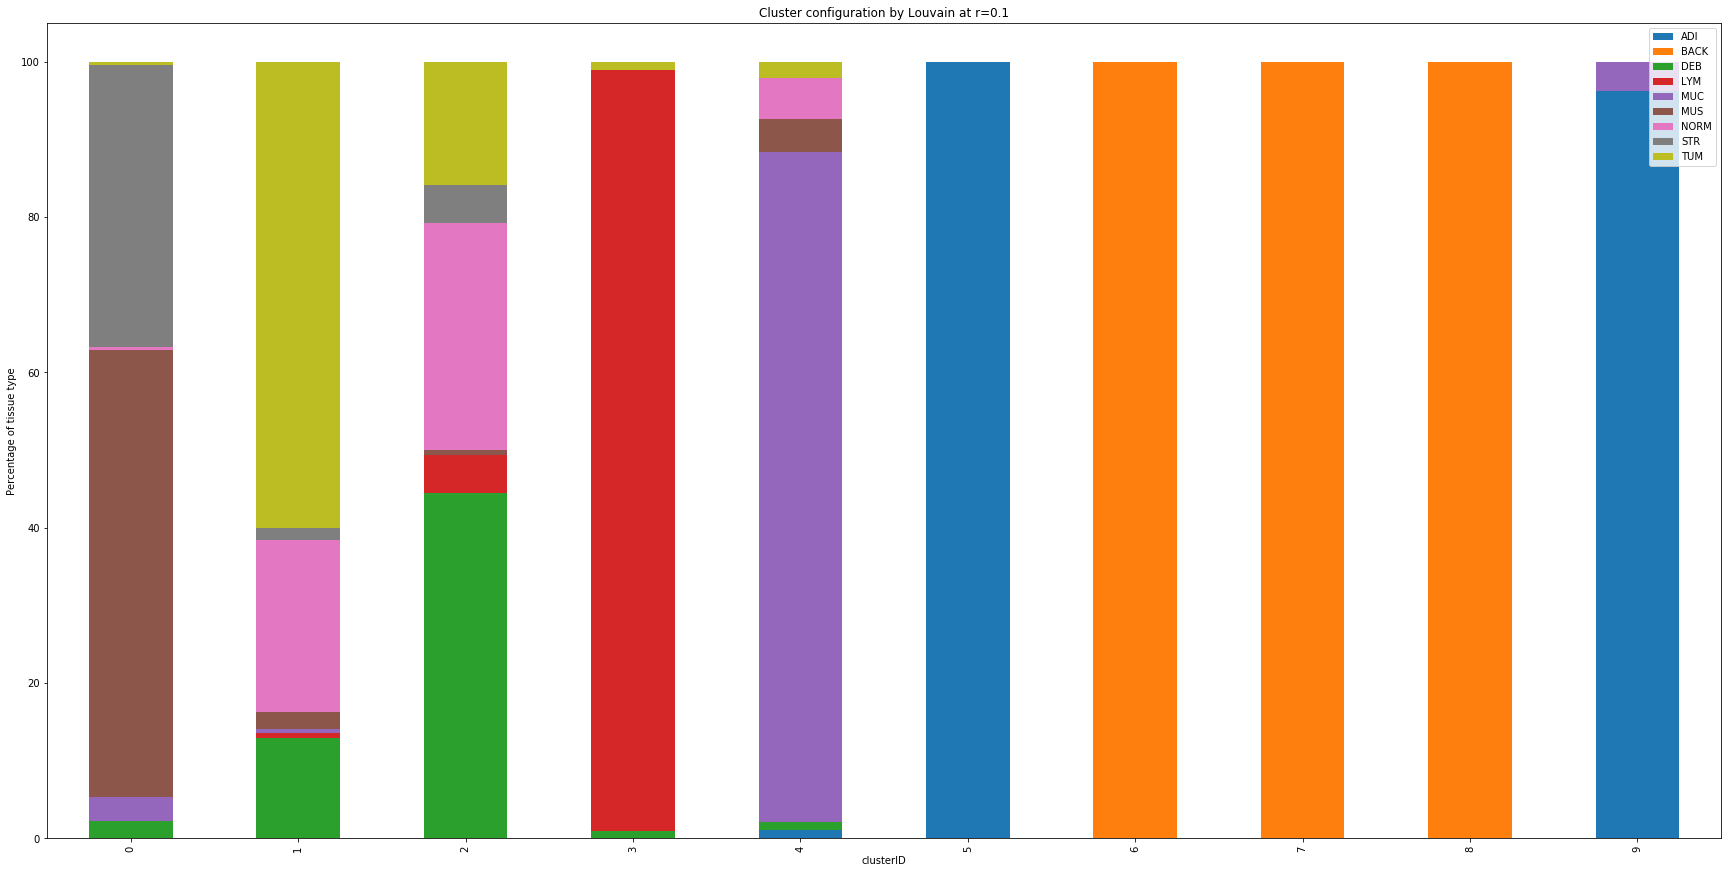

In [24]:


# Create a DataFrame for cluster IDs and labels
resulted_cluster_df = pd.DataFrame({'clusterID': louvain_labels, 'type': test_label})

# Function to calculate percentages within each cluster
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df / cnt)

# Calculate the label proportions for each cluster
label_proportion_df = (
    resulted_cluster_df
    .groupby(['clusterID'])
    .apply(lambda x: calculate_percent(x, 'type'))
    .rename(columns={'clusterID': 'type_occurrence_percentage'})
    .reset_index()
)

# Pivot the DataFrame for stacked bar plotting
pivoted_label_proportion_df = pd.pivot_table(
    label_proportion_df,
    index='clusterID',
    columns='type',
    values='type_occurrence_percentage'
)

# Plot the stacked bar graph
f, axes = plt.subplots(figsize=(30, 15))
number_of_tile_df = (
    resulted_cluster_df
    .groupby('clusterID')['type']
    .count()
    .reset_index()
    .rename(columns={'type': 'number_of_tile'})
)

df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df * 100).loc[df_idx].plot.bar(stacked=True, ax=axes)

# Configure graph labels, title, and legend
axes.set_ylabel('Percentage of tissue type')
axes.legend(loc='upper right')
axes.set_title('Cluster configuration by Louvain at r=0.1')

# Save and show the graph
f.savefig('Graphvg16pca_Louvain.png')
f.show()


Evaluating metrics with varying values of resolution

Seeing the best results for varying values of resolution Louvain(resolution=values__)


Evaluating Louvain with resolution = 0.1

Evaluating Louvain with resolution = 0.2

Evaluating Louvain with resolution = 0.30000000000000004

Evaluating Louvain with resolution = 0.4

Evaluating Louvain with resolution = 0.5

Evaluating Louvain with resolution = 0.6000000000000001

Evaluating Louvain with resolution = 0.7000000000000001

Evaluating Louvain with resolution = 0.8

Evaluating Louvain with resolution = 0.9

Evaluating Louvain with resolution = 1.0

Evaluating Louvain with resolution = 1.1

Evaluating Louvain with resolution = 1.2000000000000002

Evaluating Louvain with resolution = 1.3

Evaluating Louvain with resolution = 1.4000000000000001

Evaluating Louvain with resolution = 1.5

Maximum V-Measure Score: 0.6927901022222686
Maximum Silhouette Score: 0.4563409984111786


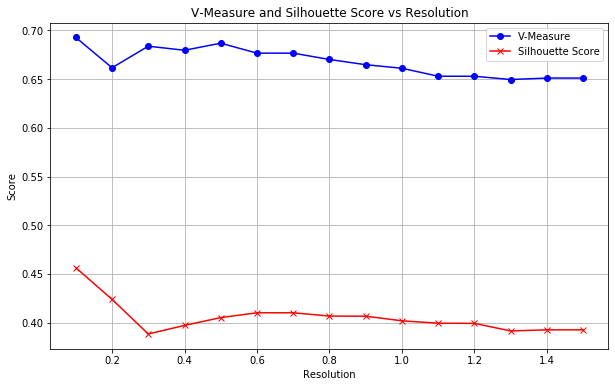

In [27]:


# Step 1: Create a nearest neighbors graph
knn_graph = kneighbors_graph(test_data, n_neighbors=10, mode='connectivity', include_self=False)
adjacency_matrix = knn_graph.toarray()

# Initialize lists to store V-Measure and Silhouette scores for each resolution
silhouette_scores = []
v_measure_scores = []

# Step 2: Loop through different values of the resolution parameter
resolution_values = [i * 0.1 for i in range(1, 16)]  # Values from 0.1 to 1.5

for resolution in resolution_values:
    print(f"\nEvaluating Louvain with resolution = {resolution}")
    
    # Apply Louvain clustering with the current resolution value
    louvain = Louvain(resolution=resolution)
    louvain_labels = louvain.fit_transform(adjacency_matrix)

    # Step 3: Calculate evaluation metrics
    try:
        louvain_silhouette = silhouette_score(test_data, louvain_labels)
        louvain_v_measure = v_measure_score(test_label, louvain_labels)
    except ValueError:
        # In case silhouette_score or v_measure_score throws an error due to invalid clustering, skip that iteration
        print("Error in evaluation metrics due to invalid clustering.")
        continue

    # Append the scores to the lists
    silhouette_scores.append(louvain_silhouette)
    v_measure_scores.append(louvain_v_measure)

# Step 4: Find maximum values of V-Measure and Silhouette scores
max_v_measure_score = max(v_measure_scores)
max_silhouette_score = max(silhouette_scores)

print(f"\nMaximum V-Measure Score: {max_v_measure_score}")
print(f"Maximum Silhouette Score: {max_silhouette_score}")

# Step 5: Plot the V-Measure and Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(resolution_values, v_measure_scores, label='V-Measure', marker='o', color='b')
plt.plot(resolution_values, silhouette_scores, label='Silhouette Score', marker='x', color='r')
plt.xlabel('Resolution')
plt.ylabel('Score')
plt.title('V-Measure and Silhouette Score vs Resolution')
plt.legend()
plt.grid(True)
plt.show()
